In [780]:
import re
import os
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt

import nltk
import email
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [781]:
def set_seed(seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [782]:
for filename in os.listdir(os.path.abspath("spam")):
    try:
        with open(os.path.join("spam", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("spam", filename), "w", encoding="utf-8") as file:
            file.write(content)
for filename in os.listdir(os.path.abspath("ham")):
    try:
        with open(os.path.join("ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

In [783]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class clean_dataset(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)
            else:
                body = b.get_payload(decode=True)  # récupérer le corp de l'email
            soup = BeautifulSoup(body, "html.parser")
            text = soup.get_text().lower()
             # dollars
            text = text.replace('$', " dollar ")
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE)  # remove links
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE)  # remove email addresses
            text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
            text = re.sub(r'\d+', 'nombre', text, flags=re.MULTILINE)
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words]  # remove stop words
            words_list = [stemmer.stem(w) for w in words_list]
            text_list.append(' '.join(words_list))
        return np.array(text_list)

In [784]:

spam = []
ham = []


#creation of the spam vocabulary
for filename in os.listdir(os.path.abspath("spam")):
    with open(os.path.join("spam", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        spam.append(mail)

#creation of the ham vocabulary
for filename in os.listdir(os.path.abspath("ham")):
    with open(os.path.join("ham", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        ham.append(mail)

print("There are", len(spam) + len(ham), "tokens in the raw vocabulary")

There are 3948 tokens in the raw vocabulary


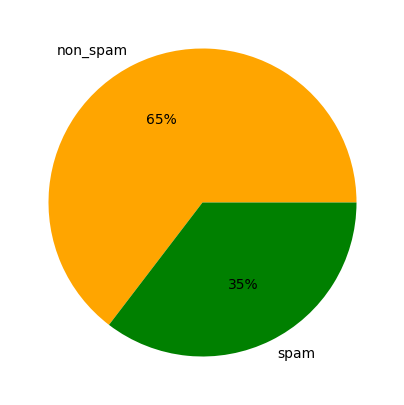

In [785]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['non_spam', 'spam']
colors = ['orange', 'green']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

In [786]:
np.random.shuffle(ham)
np.random.shuffle(spam)

In [787]:
email_to_text = clean_dataset()
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

C:\Users\Asus Zenbook Flip\AppData\Local\Temp\ipykernel_3272\3939582393.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(body, "html.parser")
C:\Users\Asus Zenbook Flip\AppData\Local\Temp\ipykernel_3272\3939582393.py:22: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(body, "html.parser")
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [788]:
print(text_spam[0])

dear homeown nombr nombr yr fix rate mortgag interest rate lowest point nombr year help find best rate situat match need hundr lender home improv refin second mortgag home equiti loan even less perfect credit click free quot lock low fix rate today ano cost pocket ano oblig afre consult aall credit grade accept rate low nombr wont stay low forev click base mortgag rate nombr low nombr see lender detail h appli one lend partner get back within nombr hour click remov pleas click


In [789]:
raw_vocab = []
for email in np.concatenate([text_spam, text_ham], axis=0):
    raw_vocab.extend(email.split())

print("Size of spam vocabulary:", len(raw_vocab))

Size of spam vocabulary: 559582


In [790]:
print(raw_vocab[0])

dear


In [791]:
#keeping words that appear at least 20 times 
vocabulary_size = 5000
bag_of_words = Counter(raw_vocab)
vocab = [x[0] for x in bag_of_words.most_common(vocabulary_size)]
print("There are", len(vocab), "different tokens after cleaning")

There are 5000 different tokens after cleaning


In [792]:
#creating the vocabulary file (dictionary)
with open("vocab.txt", "w", encoding="utf-8") as f:
    for word in vocab:
        f.write(word + "\n")

In [793]:
#Mapping
word_to_index = {}
index_to_word = {}
for index, word in enumerate(vocab): #assign index to words in vocab
    word_to_index[word] = index + 1 #index=word
    index_to_word[index + 1] = word #index=number

In [794]:
#for this function ilies khdm biha fhis class "MailDataset" bsh idk elle sert a quoi apres, we'll see ida s7a9inaha
#La fonction prend une liste de tokens en entrée et renvoie une liste d'entiers encodant ces tokens en utilisant un dictionnaire word_to_index qui associe chaque mot à un indice unique. La fonction filtre également les tokens qui ne sont pas présents dans le dictionnaire word_to_index.
def transform(tokens):
    #what about raw_vocab(exluding and,ect) and taking only >5000
    encoded_tokens = [word_to_index.get(word, 0) for word in tokens if word in word_to_index]
    return encoded_tokens

In [795]:
vocab[1]

'dollar'

In [796]:
indexed_spam = []
indexed_ham = []
#tokenize and encode the spam emails and updating mails list
for email in text_spam:
    mail = [0] + transform(email)
    indexed_spam.append(mail)

#tokenize and encode the ham emails and updating mails list
for email in text_ham:
    mail = [0] + transform(email)
    indexed_ham.append(mail)


In [797]:
print(indexed_spam[98])
print(len(indexed_spam))
print(len(indexed_ham))

[0, 769, 295, 294, 399, 1344, 566, 399, 1344, 399, 852, 769, 852, 294, 566, 294, 399, 1828, 1226, 294, 1025, 294, 1769, 1025, 584, 399, 294, 587, 399, 769, 399, 294, 1344, 1025, 294, 1769, 566, 399, 1344, 1025, 294, 1769, 294, 1828, 1226, 295, 566, 399, 769, 399, 294, 399, 769, 1344, 769, 1199, 399, 294, 399, 769, 1344, 769, 294, 399, 1226, 295, 399, 769, 852, 294, 1025, 294, 399, 295, 295, 566, 295, 769, 1769, 399, 294, 1025, 294, 399, 1769, 399, 769, 399, 399, 566, 1344, 399, 566, 566, 1025, 294, 1769, 1025, 294, 1703, 1025, 566, 1226, 1344, 566, 738, 399, 769, 399, 769, 738, 294, 399, 399, 1025, 584, 1199, 769, 769, 852, 294, 769, 566, 399, 295, 769, 1025, 566, 399, 1769, 295, 399, 566, 769, 1025, 738, 1226, 399, 566, 566, 769, 399, 769, 769, 1344, 1226, 294, 769, 399, 738, 1226, 566, 566, 294, 399, 738, 1226, 769, 738, 294, 399, 1226, 566, 584, 1199, 769, 1199, 294, 399, 399, 769, 1199, 399, 1025, 1226, 294, 295, 1199, 295, 566, 295, 1703, 1226, 769, 1226, 852, 295, 294, 852, 294, 

In [798]:
def email_to_feature_vector(email, vocab_list):
    feature_vector = [0] * len(vocab_list)
    words = set(email)
    for i, word in enumerate(vocab_list):
        if word in words:
            feature_vector[i] = 1
    return feature_vector

In [799]:
indexes = list(word_to_index.values())
spam_features = [email_to_feature_vector(email, indexes) for email in indexed_spam]
ham_features = [email_to_feature_vector(email, indexes) for email in indexed_ham]

In [800]:
spam_features_array = np.array(spam_features).reshape((len(spam_features), -1))
ham_features_array = np.array(ham_features).reshape((len(ham_features), -1))

# Print the shape of the array
print(spam_features_array.shape)
print(ham_features_array.shape)

(1397, 5000)
(2551, 5000)


In [801]:
# Create an array of labels (1 for spam, 0 for ham)
spam_labels = np.ones((len(spam_features_array), 1))
ham_labels = np.zeros((len(ham_features_array), 1))

# concatenate the label arrays with the feature arrays along axis 1
labeled_spam_features = np.concatenate((spam_features_array, spam_labels), axis=1)
labeled_ham_features = np.concatenate((ham_features_array, ham_labels), axis=1)

# concatenate the spam and ham arrays into a single array
labeled_features = np.concatenate((labeled_spam_features, labeled_ham_features), axis=0)

# Shuffle the data
np.random.shuffle(labeled_features)

In [802]:
X = labeled_features[:, :-1]
y = labeled_features[:, -1]

In [803]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [804]:
print("Number of training emails: ", len(X_train))
print("Number of testing emails: ", len(X_test))
print(X_train.shape)

Number of training emails:  2763
Number of testing emails:  1185
(2763, 5000)


In [805]:
bin_svm_model = svm.SVC(C=0.1, kernel="linear", random_state=seed)
bin_svm_model.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', random_state=42)

In [806]:
test_prediction = bin_svm_model.predict(X_test)

test_accuracy = (test_prediction == y_test).mean() * 100

print("test accuracy: {0:.10f}%".format(test_accuracy))

test accuracy: 69.7890295359%


In [807]:
rain_prediction_scores = bin_svm_model.decision_function(train_X)
test_prediction_scores = bin_svm_model.decision_function(test_X)

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

ValueError: X has 5606 features, but SVC is expecting 5000 features as input.